[View in Colaboratory](https://colab.research.google.com/github/scon012/722-Iteration-4/blob/master/722_Iteration_4_Google.ipynb)

In [0]:
# For AWS
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
#import findspark
#findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
#import pyspark
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName('missing').getOrCreate()



In [4]:
# For Google Step 1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.2.2/spark-2.2.2-bin-hadoop2.7.tgz
!tar xf spark-2.2.2-bin-hadoop2.7.tgz
!pip install -q findspark


Redirecting output to ‘wget-log’.


In [0]:
# For Google Step 2
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.2-bin-hadoop2.7"

In [0]:
# For Google Step 3
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

######################################################################################################
### Configure the environment
######################################################################################################

In [0]:
# Other environment imports
from pyspark.sql.functions import datediff, to_date, lit, when, date_sub, col
from pyspark.ml.feature import ChiSqSelector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

######################################################################################################
### Get and inspect the data
######################################################################################################

In [0]:
# Get the data for Google

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [7]:
# Get the data files on AWS
standings1617 = spark.read.csv("2016-17_standings.csv", header=True, inferSchema=True)
standings1617.show(5)

standings1718 = spark.read.csv("2017-18_standings.csv", header=True, inferSchema=True)
standings1718.show(5)

boxScore1617 = spark.read.csv("2016-17_teamBoxScore.csv", header=True, inferSchema=True)
boxScore1617.show(5)

boxScore1718 = spark.read.csv("2017-18_teamBoxScore.csv", header=True, inferSchema=True)
boxScore1718.show(5)
boxScore1718.head(5)


+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+--------+---+---+---+----------+----------+----------+---------+---------+---------+
|             stDate|teamAbbr|rank|rankOrd|gameWon|gameLost|stk|stkType|stkTot|gameBack|ptsFor|ptsAgnst|homeWin|homeLoss|awayWin|awayLoss|confWin|confLoss|lastFive|lastTen|gamePlay|ptsScore|ptsAllow|ptsDiff|opptGmPlay|opptGmWon|opptOpptGmPlay|opptOpptGmWon|sos|rel%Indx|mov|srs|pw%|pyth%13.91|wpyth13.91|lpyth13.91|pyth%16.5|wpyth16.5|lpyth16.5|
+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+--------+---+---+---+----------+----------+----

[Row(gmDate=datetime.datetime(2017, 10, 17, 0, 0), gmTime='08:00', seasTyp='Regular', offLNm1='Forte', offFNm1='Brian', offLNm2='Smith', offFNm2='Michael', offLNm3='McCutchen', offFNm3='Monty', teamAbbr='BOS', teamConf='East', teamDiv='Atlantic', teamLoc='Away', teamRslt='Loss', teamMin=241, teamDayOff=0, teamPTS=99, teamAST=24, teamTO=12, teamSTL=11, teamBLK=4, teamPF=24, teamFGA=88, teamFGM=36, teamFG%=0.4091, team2PA=56, team2PM=28, team2P%=0.5, team3PA=32, team3PM=8, team3P%=0.25, teamFTA=25, teamFTM=19, teamFT%=0.76, teamORB=9, teamDRB=37, teamTRB=46, teamPTS1=19, teamPTS2=19, teamPTS3=33, teamPTS4=28, teamPTS5=0, teamPTS6=0, teamPTS7=0, teamPTS8=0, teamTREB%=47.9167, teamASST%=66.6667, teamTS%=0.5, teamEFG%=0.4545, teamOREB%=18.0, teamDREB%=80.4348, teamTO%=10.8108, teamSTL%=10.9692, teamBLK%=3.9888, teamBLKR=7.1429, teamPPS=1.125, teamFIC=75.375, teamFIC40=62.5519, teamOrtg=98.7227, teamDrtg=101.7143, teamEDiff=-2.9916, teamPlay%=0.3956, teamAR=17.7778, teamAST/TO=2.0, teamSTL/T

######################################################################################################
### For the Box Score preparation - the next set of steps are for the box score data preparation
######################################################################################################

In [10]:
# Create column for the "days since" the start of the season for 2016/17

boxScore1617 = boxScore1617.withColumn('daysSince', datediff(to_date(boxScore1617['gmDate']), to_date(lit('2016-10-25'))))
boxScore1617.show(5)

+-------------------+------+-------+-------+-------+--------+-------+--------+-------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+-------+--------+---------+---------+-------+--------+--------+--------+-------+-------+---------+--------+--------+---------+---------+-------+----------+----------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+-------+--------+---------+---------+-------+--------+--------+--------+-------+-------+---------+------

In [11]:
# Create column for the "days since" the start of the season for 2017/18

boxScore1718 = boxScore1718.withColumn('daysSince', datediff(to_date(boxScore1718['gmDate']), to_date(lit('2016-10-17'))))
boxScore1718.show(5)

+-------------------+------+-------+-------+-------+---------+-------+---------+-------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+-------+--------+---------+---------+-------+--------+--------+--------+-------+-------+---------+--------+--------+---------+---------+-------+----------+----------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+-------+--------+---------+---------+-------+--------+--------+--------+-------+-------+---------+----

In [12]:
# Merge the two years dataframes of Games Played data
boxScoreAll = boxScore1617.union(boxScore1718)

print("Box Score 1617:", boxScore1617.count())
print("Box Score 1718:", boxScore1718.count())
print("Box Score All:", boxScoreAll.count())

Box Score 1617: 2460
Box Score 1718: 2460
Box Score All: 4920


In [13]:
# Remove all the "Away" perspective records by selecting only the "Home" records
boxScoreAll = boxScoreAll.filter('teamLoc = "Home"')
print("Box Score All:", boxScoreAll.count())

Box Score All: 2460


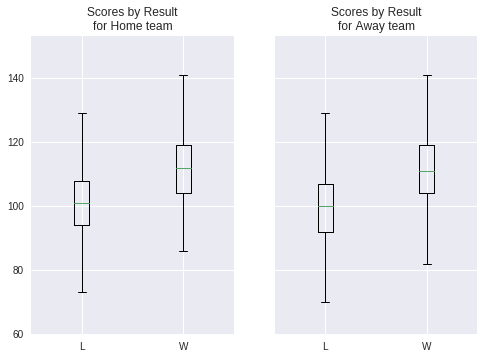

In [14]:
# Visualize the Outliers

myBS = pd.DataFrame(boxScoreAll.take(5000))

plotData = pd.DataFrame(myBS, columns = [13, 16]).rename(inplace=False, index = str, columns = {13:"teamRslt",16:'teamPTS'}).pivot(columns='teamRslt')

# Remove the NaN values from the array and make into a list because they will not be the same length
plotdata = np.array(plotData)
mask = ~np.isnan(plotdata)
plotdata = [d[m] for d, m in zip(plotdata.T, mask.T)]

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
axes[0].boxplot(plotdata, showfliers = True, labels=list('LW'))
axes[0].set_title("Scores by Result\nfor Home team")

# Repeat again for the away team
plotData = pd.DataFrame(myBS, columns = [69, 72]).rename(inplace=False, index = str, columns = {69:"teamRslt",72:'teamPTS'}).pivot(columns='teamRslt')
plotdata = np.array(plotData)
mask = ~np.isnan(plotdata)
plotdata = [d[m] for d, m in zip(plotdata.T, mask.T)]

axes[1].boxplot(plotdata, showfliers = True, labels=list('LW'))
axes[1].set_title("Scores by Result\nfor Away team")

fig.subplots_adjust(hspace=50)
plt.show()

In [0]:
# Compare Home Win/Loss record with scatterplot






# To do




In [15]:
# Remove the columns that are not known before the game starts by selecting the columns that do.
boxScoreAll = boxScoreAll.select('gmDate','gmTime','seasTyp','offLNm1','offFNm1','offLNm2','offFNm2','offLNm3','offFNm3','teamAbbr','teamConf','teamDiv','teamLoc','teamRslt','teamDayOff','opptAbbr','opptConf','opptDiv','opptLoc','opptDayOff','daysSince')
boxScoreAll.show(5)

+-------------------+------+-------+--------+-------+--------+-------+----------+-------+--------+--------+---------+-------+--------+----------+--------+--------+---------+-------+----------+---------+
|             gmDate|gmTime|seasTyp| offLNm1|offFNm1| offLNm2|offFNm2|   offLNm3|offFNm3|teamAbbr|teamConf|  teamDiv|teamLoc|teamRslt|teamDayOff|opptAbbr|opptConf|  opptDiv|opptLoc|opptDayOff|daysSince|
+-------------------+------+-------+--------+-------+--------+-------+----------+-------+--------+--------+---------+-------+--------+----------+--------+--------+---------+-------+----------+---------+
|2016-10-25 00:00:00| 08:00|Regular|    Lane|   Karl|   Adams| Bennie|   Kennedy|   Bill|     CLE|    East|  Central|   Home|     Win|         0|      NY|    East| Atlantic|   Away|         0|        0|
|2016-10-25 00:00:00| 10:00|Regular| Buchert|   Nick|Callahan|   Mike|     Brown|   Tony|     POR|    West|Northwest|   Home|     Win|         0|     UTA|    West|Northwest|   Away|       

In [0]:
# Find any cells that are null

In [0]:
# Populate the null cells with data gathered from the NBA

In [16]:
# Fix the rows that have the wrong times - they need 12hr deducted from their times
boxScoreAll.filter('gmTime > "12:30"').select('gmtime').show()

boxScoreAll = boxScoreAll.withColumn("gmTime", when(boxScoreAll["gmTime"] > '12:30', boxScoreAll["gmTime"] - '12:00').otherwise(boxScoreAll["gmTime"]))

boxScoreAll.filter('gmTime > "12:30"').select('gmtime').show()

+------+
|gmtime|
+------+
| 18:00|
| 18:00|
| 19:00|
| 19:00|
+------+

+------+
|gmtime|
+------+
+------+



In [0]:
# Compare Home Win/Loss record with bar graph






# To do




######################################################################################################
### For the Standings preparation - the next set of steps are for the standings data preparation
######################################################################################################

In [17]:
# Join the two years datasets
standingsAll = standings1617.union(standings1718)
standingsAll.show(1)

# Rename the 'teamAbbr' column to prevent clash later
standingsAll = standingsAll.withColumnRenamed('teamAbbr', 'steamAbbr')
standingsAll.show(1)

print("Standings 1617:", standings1617.count())
print("Standings 1718:", standings1718.count()) 
# There are more standings rows in the 17/18 dataset because the season runs for a week longer
print("Standings All:", standingsAll.count())

+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+--------+---+---+---+----------+----------+----------+---------+---------+---------+
|             stDate|teamAbbr|rank|rankOrd|gameWon|gameLost|stk|stkType|stkTot|gameBack|ptsFor|ptsAgnst|homeWin|homeLoss|awayWin|awayLoss|confWin|confLoss|lastFive|lastTen|gamePlay|ptsScore|ptsAllow|ptsDiff|opptGmPlay|opptGmWon|opptOpptGmPlay|opptOpptGmWon|sos|rel%Indx|mov|srs|pw%|pyth%13.91|wpyth13.91|lpyth13.91|pyth%16.5|wpyth16.5|lpyth16.5|
+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+--------+---+---+---+----------+----------+----

##################################################################################
### Merge the standings data into the box score data
##################################################################################

In [18]:
# Home team data
boxWithStand = boxScoreAll.join(standingsAll, (boxScoreAll.teamAbbr == standingsAll.steamAbbr) & (date_sub(boxScoreAll.gmDate, 1) == to_date(standingsAll.stDate)))
print(boxScoreAll.count())
print(boxWithStand.count())

2460
2460


In [19]:
# Away team data

# Rename columns by adding a suffix so that there are no name clashes
opptStandings = standingsAll.select(*(col(x).alias(x + '_oppt') for x in standingsAll.columns))

# Join the tables
boxWithStand = boxWithStand.join(opptStandings, (boxScoreAll.opptAbbr == opptStandings.steamAbbr_oppt) & (date_sub(boxScoreAll.gmDate, 1) == to_date(opptStandings.stDate_oppt)))
print(boxScoreAll.count())
print(boxWithStand.count())


AnalysisException: ignored

In [0]:
# Compare Win/Loss record with rank






# To do




##################################################################################

Split the data and prepare for Machine Learning
##################################################################################

In [0]:
##############
# Training data - get all the rows that are pre 2018-01-01

In [0]:
trainingData = boxWithStand.filter('gmDate < "2018-01-01"')
trainingData.count()

1774

In [0]:
##############
# Test data - get all the rows that are between 2018-01-01 and 2018-02-07

In [0]:
testData = boxWithStand.filter('gmDate >= "2018-01-01" AND gmDate <= "2018-02-07"')
testData.count()

260

In [0]:
######################
# Feature Selection

In [0]:
#selector = ChiSqSelector(numTopFeatures=50, featuresCol="features", outputCol="selectedFeatures", labelCol="teamRslt")
#selector = ChiSqSelector(numTopFeatures=50, outputCol="selectedFeatures", labelCol="teamRslt")
selector = ChiSqSelector(numTopFeatures=50, labelCol="teamRslt", outputCol = "selectedFeatures")
chiData = trainingData.select('gmDate', 'gameBack', 'ptsAgnst', 'ptsFor', 'stkTot', 'ptsDiff', 'homeWin', 'awayWin')
result = selector.fit(trainingData).transform(trainingData)

#print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.show()

IllegalArgumentException: 'Field "paj" does not exist.'

In [0]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

df = spark.createDataFrame([
    (7, Vectors.dense([0.0, 0.0, 18.0, 1.0]), 1.0,),
    (8, Vectors.dense([0.0, 1.0, 12.0, 0.0]), 0.0,),
    (9, Vectors.dense([1.0, 0.0, 15.0, 0.1]), 0.0,)], ["id", "features", "clicked"])

selector = ChiSqSelector(numTopFeatures=1, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="clicked")

result = selector.fit(df).transform(df)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.show()

ChiSqSelector output with top 1 features selected
+---+------------------+-------+----------------+
| id|          features|clicked|selectedFeatures|
+---+------------------+-------+----------------+
|  7|[0.0,0.0,18.0,1.0]|    1.0|          [18.0]|
|  8|[0.0,1.0,12.0,0.0]|    0.0|          [12.0]|
|  9|[1.0,0.0,15.0,0.1]|    0.0|          [15.0]|
+---+------------------+-------+----------------+



In [0]:
# Select the columns chosen by Feature Selection

In [0]:
# Split the Training data into 70 Training & 30 Validation